# Checkerboard Microstructure

## Introduction - What are 2-Point Spatial Correlations (also called 2-Point Statistics)?

This example computes both periodic and non-periodic 2-point spatial correlations (also referred to as 2-point stats or auto-correlations and cross-correlations) for a checkerboard microstructure. This is a simple example to demonstrate how spatial correlations capture features seen in the original microstructure. More technical details about 2-point statistics are in the [theory section](../../THEORY.html).

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from numpy import allclose
from pymks.fmks.data.checkerboard import generate
from pymks.fmks.plot import plot_microstructures
from sklearn.pipeline import Pipeline
from pymks.fmks.bases.primitive import PrimitiveTransformer
from pymks.fmks.correlations import TwoPointCorrelation

## 2-Point Statistics for Checkerboard Microstructure

Let's generate a microstructure that looks like a 8 x 8 checkerboard. Although this microstructure does not resemble a physical system, it is a good example to develop an intuitive understanding of 2-point statistics.

We can create a checkerboard microstructure using the `generate` function from `pymks.fmks.data.checkerboard`.

In [2]:
x_data = generate(
    size=(21 * 8, 21 * 8),
    square_shape=(21, 21)
)

Now let's take a look at how the microstructure looks using the `plot_microstructures` helper function.

(1, 168, 168)


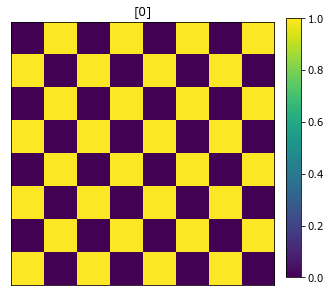

In [3]:
plot_microstructures(x_data[0], titles=['[0]'])
print(x_data.shape)

## Compute Periodic 2-Point Statistics

Now that we have created a microstructure to work with, we can start computing the 2-point stats. Let's first compute the periodic 2-points stats using the `TwoPointCorrelation` class. The `periodic_boundary` argument is set to `True`. In order to compute 2-point stats, we need to first discretize the microstructure using a chosen basis. As we only have values of 0 or 1 in our microstructure we will use the `PrimitiveTransformer` with `n_state` equal to 2. The `PrimitiveTransformer` and the `TwoPointCorrelation` are combined into a Scikit-learn pipeline to generate a model. The `transform` method executes the pipeline as this is not a model that requires a `predict` step to use. 

In [11]:
model = Pipeline(steps=[
    ('discretize', PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ('correlations', TwoPointCorrelation(
        periodic_boundary=True, 
        cutoff=x_data.shape[1],
        correlations=[[0, 0], [1, 1], [0, 1]]
    ))
])

print(x_data.shape)
x_stats = model.transform(x_data).compute() 
print(x_stats.shape)

(1, 168, 168)
(1, 167, 167, 3)


We have now computed the 2-point stats. We first plot the auto-correlations.

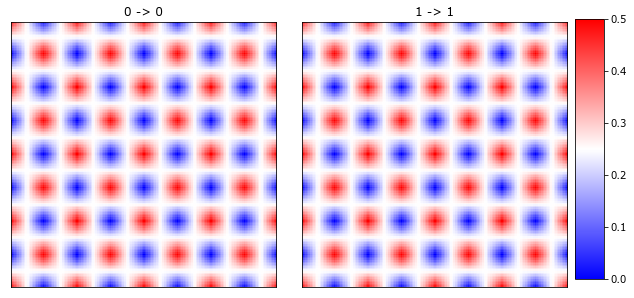

In [12]:
plot_microstructures(x_stats[0, :, :, 0], x_stats[0, :, :, 1], titles=['0 -> 0', '1 -> 1'], cmap='bwr')

and then the cross-correlations

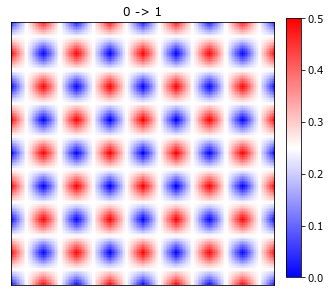

In [13]:
plot_microstructures(x_stats[0, :, :, 2], titles=['0 -> 1'], cmap='bwr')

Notice that for this checkerboard microstructure, the correlations are offset, but with the same values. We have just computed the periodic correlations for a perfectly periodic microstructure with equal volume fractions. In general this is not the case and the correlations will not match the microstructure.

As mentioned in the introduction, because we using an indicator basis and are using eigen microstructure functions (values are either 0 or 1), then the (0, 0) vector equals the volume fraction for an autocorrelation.

Notice that the crosscorrelation (0 -> 1) is the exact opposite of the autocorrelation (0 -> 0). The (0, 0) vector has a value of 0. This statistic reflects the probablity of 2 phases having the same location. In our microstructure, this probability is zero, as we have not allowed the two phases (colored black and white) to co-exist in the same spatial voxel.

Let's double check the center points have the correct values.

In [14]:
center = x_stats.shape[1] // 2

print('Volume fraction of 0 -> 0: ', allclose(x_stats[0, center, center, 0], 0.5))
print('Volume fraction of 0 -> 1: ', allclose(x_stats[0, center, center, 2], 0))

Volume fraction of 0 -> 0:  True
Volume fraction of 0 -> 1:  True


## Compute Non-Periodic 2-Point Statistics

We will now compute the non-periodic 2-point statistics for our microstructure. This time, rather than using the `autocorrelate` and `crosscorrelate` functions, we will use the `correlate` function from `pymks.stats`. The `correlate` function computes all of the autocorrelations and crosscorrelations at the same time. We will compute the non-periodic statistics by omitting the keyword argument `periodic_axes`.

In [17]:
model = Pipeline(steps=[
    ('discretize', PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ('correlations', TwoPointCorrelation(
        periodic_boundary=False,
        cutoff=x_data.shape[1],
        correlations=[[0, 0], [1, 1], [0, 1]]
    ))
])

x_stats = model.transform(x_data).compute() 
x_stats.shape

(1, 167, 167, 3)

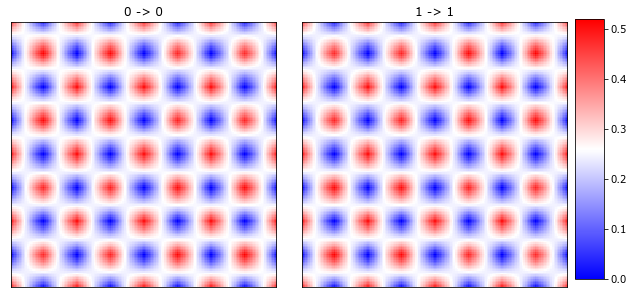

In [18]:
plot_microstructures(x_stats[0, :, :, 0], x_stats[0, :, :, 1], titles=['0 -> 0', '1 -> 1'], cmap='bwr')

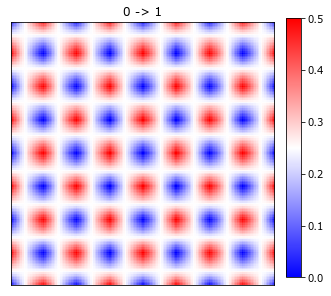

In [19]:
plot_microstructures(x_stats[0, :, :, 2], titles=['0 -> 1'], cmap='bwr')

Notice that the maximum values for the autocorrelations are higher than 0.5 due to the non-periodicity and that the (red -> red) or (blud -> blue) diagonals are more curved compared with the periodic stats.

We can still show that the centers or the (0, 0) vectors are still equal to the volume fractions.

In [21]:
print('Volume fraction of black phase', x_stats[0, center, center, 0])
print('Volume fraction of white phase', x_stats[0, center, center, 1])

Volume fraction of black phase 0.5
Volume fraction of white phase 0.5


The non-periodic statistics are different from the periodic 2-point statistics along the diagonal vectors, but in both cases the probability of (0, 0) vector is still the volume fraction.

## References

[1] S.R. Niezgoda, D.T. Fullwood, S.R. Kalidindi, Delineation of the Space of 2-Point Correlations in a Composite Material System, Acta Materialia, 56, 18, 2008, 5285–5292 [doi:10.1016/j.actamat.2008.07.005](http://dx.doi.org/10.1016/j.actamat.2008.07.005)

 
[2] S.R. Niezgoda, D.M. Turner, D.T. Fullwood, S.R. Kalidindi, Optimized Structure Based Representative Volume Element Sets Reflecting the Ensemble-Averaged 2-Point Statistics, 58, 13, 2010, 4432–4445  [doi:10.1016/j.actamat.2010.04.041](http://dx.doi.org/10.1016/j.actamat.2010.04.041)


[3] D.T. Fullwood, S.R. Kalidindi, and B.L. Adams, Second - Order Microstructure Sensitive Design Using 2-Point Spatial  Correlations, Chapter 12 in Electron Backscatter Diffraction in Materials Science , 2nd Edition , Eds. A. Schwartz, M. Kumar, B. Adams, D. Field, Springer, NY, 2009. 